Esse notebook é uma tradução do [artigo](https://towardsdatascience.com/a-complete-machine-learning-project-walk-through-in-python-part-two-300f1f8147e2) originalmente escrito por [William Koehrsen](https://twitter.com/koehrsen_will) no site [Towards Data Science](https://towardsdatascience.com)

# Um projeto completo de aprendizado de máquina em Python - Parte 2

Montar todas as peças de aprendizado de máquina necessárias para resolver um problema pode ser uma tarefa assustadora. Nesta série de artigos, estamos caminhando para implementar um fluxo de trabalho de aprendizado de máquina usando um conjunto de dados do mundo real para ver como as técnicas individuais se juntam.

No primeiro [notebook](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20One.ipynb), limpamos e estruturamos os dados, fizemos uma análise exploratória de dados, desenvolvemos um conjunto de features para usar em nosso modelo e estabelecemos uma linha de base em relação à qual podemos medir o desempenho. Neste artigo, veremos como implementar e comparar vários modelos de aprendizado de máquina no Python, executar o ajuste de hiperparâmetros para otimizar o melhor modelo e avaliar o modelo final no conjunto de testes.

# Imports

Abaixo estão as bibliotecas que serão utilizadas nesse notebook:

In [1]:
# Pandas e numpy para manipulação dos dados
import pandas as pd
import numpy as np

# Desativa alguns warnings
pd.options.mode.chained_assignment = None

# Altera o padrão do número de colunas exibidas pelo pandas para 60
pd.set_option('display.max_columns', 60)

# Matplotlib para visualização dos dados
import matplotlib.pyplot as plt
%matplotlib inline

# Altera o tamanho da fonte padrão
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn para visualização
import seaborn as sns
sns.set(font_scale = 2)

# Atribuição para valores faltantes e padrões de escala de valores
from sklearn.preprocessing import Imputer, MinMaxScaler

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Avaliação e Seleção de Modelos

Lembramos que estamos trabalhando em uma tarefa de regressão supervisionada: usando os [dados de energia de edifícios da cidade de Nova York](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml), queremos desenvolver um modelo que possa prever a pontuação [Energy Star](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what) de um edifício. Nosso foco está na precisão das previsões e interpretabilidade do modelo.

Há uma[ tonelada de modelos de aprendizado de máquina](http://scikit-learn.org/stable/supervised_learning.html) para escolher e decidir por onde começar pode ser intimidante. Embora existam [alguns gráficos](https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-cheat-sheet) que tentam mostrar qual algoritmo usar, prefiro apenas experimentar vários e ver qual deles funciona melhor! O aprendizado de máquina ainda é um campo impulsionado principalmente por [resultados empíricos (experimentais) e não teóricos](https://www.quora.com/How-much-of-deep-learning-research-is-empirical-versus-theoretical), e é quase impossível [saber com antecedência qual modelo fará o melhor](http://www.statsblogs.com/2014/01/25/machine-learning-lesson-of-the-day-the-no-free-lunch-theorem/).

Geralmente, é uma boa ideia começar com modelos simples e interpretáveis, como a regressão linear, e, se o desempenho não for adequado, passar para métodos mais complexos, mas geralmente mais precisos. O gráfico a seguir mostra uma versão (altamente não científica) da relação entre precisão e interpretabilidade:

![alt text](https://cdn-images-1.medium.com/max/800/1*NkffR5Ufy_h4RfSVpTJ2iQ.png)

Vamos avaliar cinco modelos diferentes cobrindo o espectro da complexidade:

- **Linear Regression**
- **K-Nearest Neighbors Regression**
- **Random Forest Regression**
- **Gradient Boosted Regression**
- **Support Vector Machine Regression**

Neste notebook, vamos nos concentrar na implementação desses métodos, em vez da teoria por trás deles. Para qualquer pessoa interessada em aprender a fundo, eu recomendo [Uma Introdução à Aprendizagem Estatística](http://www-bcf.usc.edu/~gareth/ISL/) (disponível on-line gratuito) ou o [Aprendizado de Máquina Prático com o Scikit-Learn e o TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Ambos os livros didáticos fazem um ótimo trabalho explicando a teoria e mostrando como usar efetivamente os métodos em R e Python, respectivamente.

# Imputando Valores Ausentes

Embora tenhamos descartado as colunas com mais de 50% de valores ausentes quando limpamos os dados, ainda há algumas observações ausentes. Os modelos de aprendizado de máquina não podem lidar com quaisquer valores ausentes, então temos que preenchê-los, um [processo conhecido como imputação](https://en.wikipedia.org/wiki/Imputation_%28statistics%29).

Primeiro, lemos todos os dados que salvamos anteriormente:

In [4]:
# Cria novos dataframes com base nos arquivos salvos anteriormente
train_features = pd.read_csv('data/energy_new_york_training_features.csv')
train_labels = pd.read_csv('data/energy_new_york_training_labels.csv')

test_features = pd.read_csv('data/energy_new_york_testing_features.csv')
test_labels = pd.read_csv('data/energy_new_york_testing_labels.csv')

# Exibe o tamanho dos dataframes
print('Training Feature Size', train_features.shape)
print('Training Labels Size ', train_labels.shape)
print('Testing Feature Size ', test_features.shape)
print('Testing Labels Size  ', test_labels.shape)

Training Feature Size (6622, 64)
Training Labels Size  (6622, 1)
Testing Feature Size  (2839, 64)
Testing Labels Size   (2839, 1)


In [5]:
# Mosstra as 10 primeiras linhas do dataframe
train_features.head(10)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

Cada valor que é `NaN` representa uma observação ausente. Embora haja [várias maneiras de preencher os dados ausentes](https://www.omicsonline.org/open-access/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.php?aid=54590), usaremos um método relativamente simples, a imputação mediana. Isso substitui todos os valores ausentes em uma coluna pelo valor mediano da coluna.

No código a seguir, criamos um objeto [Scikit-Learn](http://scikit-learn.org/stable/) `Imputer` com a estratégia definida como mediana. Em seguida, treinamos esse objeto nos dados de treinamento (usando `imputer.fit`) e o usamos para preencher os valores ausentes nos dados de treinamento e teste (usando `imputer.transform`). **Isso significa que os valores ausentes nos dados de teste são preenchidos com o valor mediano correspondente dos dados de treinamento**.

(Temos que fazer a imputação dessa maneira, em vez de treinar todos os dados para evitar o problema de [vazamento de dados de teste](https://www.kaggle.com/dansbecker/data-leakage), em que as informações do conjunto de dados de teste se espalham para os dados de treinamento.)


In [6]:
# Cria um imputer definido com estratégia para preenchimento com a mediana
imputer = Imputer(strategy='median')

# Treina o imputer com o dataframe de treinamento
imputer.fit(train_features)

# Transforma o conjunto de treinamento e teste conforme o imputer
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [7]:
print('Valores ausentes no conjunto de treinamento:', np.sum(np.isnan(X)))
print('Valores ausentes no conjunto de teste:', np.sum(np.isnan(X_test)))

Valores ausentes no conjunto de treinamento: 0
Valores ausentes no conjunto de teste: 0


In [8]:
# Verifica se todos os valores são finitos
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Após a imputação, todos as features estão com valores reais e finitos, sem valores ausentes. Para métodos mais sofisticados de imputação (embora os valores medianos usualmente funcionem bem) confira este [artigo](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146).

# Dimensionamento de features

[Dimensionamento](https://en.wikipedia.org/wiki/Feature_scaling) refere-se ao processo geral de alterar o intervalo de uma feature. [Isso é necessário](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data) porque as features são medidas em diferentes unidades e, portanto, cobrem diferentes faixas. Métodos como [SVM](https://stats.stackexchange.com/questions/305906/feature-scaling-in-svm-does-it-depend-on-the-kernel) e KNN que levam em consideração as medidas de distância entre observações são significativamente afetados pela faixa das features e aplicação de dimensionamento permite que eles aprendam. Embora métodos como [Regressão Linear e Floresta Aleatória](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data) não requeiram realmente o dimensionamento de features, ainda é recomendável seguir essa etapa quando estamos comparando vários algoritmos.

Vamos escalar as features colocando cada uma em um intervalo entre 0 e 1. Isso é feito tomando cada valor de uma feature, subtraindo o valor mínimo da feature e dividindo pelo máximo menos o mínimo (o intervalo). Essa versão específica do escalonamento é geralmente chamada de [normalização e a outra versão principal é conhecida como padronização](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

Enquanto este processo seria fácil de implementar manualmente, podemos fazê-lo usando um objeto `MinMaxScaler` no Scikit-Learn. O código para esse método é idêntico ao da imputação, exceto com um `scaler` em vez de `imputer`! Mais uma vez, nos certificamos de treinar apenas usando dados de treinamento e então transformamos todos os dados.

In [9]:
# Cria o objeto scaler com uma faixa de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Treina o scaler com o conjunto de treino das features (já feito imput anteriorment)
scaler.fit(X)

# Transforma o conjunto de treino e teste
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [10]:
# Converte os dados de saída (score) para um array de uma dimensão (vetor)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

Cada feature agora tem um valor mínimo de 0 e um valor máximo de 1. A imputação de valor ausente e o dimensionamento de features são duas etapas necessárias em quase todos os `pipelines` de aprendizado de máquina, por isso é uma boa ideia entender como eles funcionam!

# Implementando Modelos de Aprendizado de Máquina no Scikit-Learn

Depois de todo o trabalho que passamos limpando e formatando os dados, criar, treinar e prever com os modelos é relativamente simples. Usaremos a [biblioteca Scikit-Learn](http://scikit-learn.org/stable/documentation.html) em Python, que possui ótima documentação e uma sintaxe consistente de construção de modelo. Depois de saber como criar um modelo no Scikit-Learn, você pode implementar rapidamente diversos algoritmos.

Abaixo serão criados alguns modelos, treinamento (usando `.fit`) e teste (usando `.predict`).

### Funções criadas para auxiliar nos algoritmos a seguir

In [11]:
# Calcula o erro absoluto médio (MAE)
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Treina e avalia o modelo e retorna a metrica do MAE
def fit_and_evaluate(model):
    
    # Treina o modelo
    model.fit(X, y)

    # Realiza as predições sobre o conjunto de teste
    predictions = model.predict(X_test)
    
    model_mae = mae(y_test, predictions)
    
    return model_mae

### Gradient Boosting Regressor

In [13]:
# Cria o modelo
gradient_boost = GradientBoostingRegressor(random_state=60)

# Treina, avalia e retorna o MAE
gradient_boost_mae = fit_and_evaluate(gradient_boost)

print('Desempenho de Gradient Boosted no conjunto de testes: MAE = %0.4f' % gradient_boost_mae)

Desempenho de Gradient Boosted no conjunto de testes: MAE = 10.0132


### Linear Regression

In [14]:
# Cria o modelo
lr = LinearRegression()

# Treina, avalia e retorna o MAE
lr_mae = fit_and_evaluate(lr)

print('Desempenho de LinearRegression no conjunto de testes: MAE = %0.4f' % lr_mae)

Desempenho de LinearRegression no conjunto de testes: MAE = 13.4651


### Support Vector Machine

In [15]:
# Cria o modelo
svm = SVR(C = 1000, gamma = 0.1)

# Treina, avalia e retorna o MAE
svm_mae = fit_and_evaluate(svm)

print('Desempenho de SVM no conjunto de testes: MAE = %0.4f' % svm_mae)

Desempenho de SVM no conjunto de testes: MAE = 10.9337


### Random Forest

In [16]:
# Cria o modelo
random_forest = RandomForestRegressor(random_state=60)

# Treina, avalia e retorna o MAE
random_forest_mae = fit_and_evaluate(random_forest)

print('Desempenho de Random Forest no conjunto de testes: MAE = %0.4f' % random_forest_mae)

Desempenho de Random Forest no conjunto de testes: MAE = 10.0147


### K-Nearest Neighbors (KNN)

In [17]:
# Cria o modelo
knn = KNeighborsRegressor(n_neighbors=10)

# Treina, avalia e retorna o MAE
knn_mae = fit_and_evaluate(knn)

print('Desempenho de KNN no conjunto de testes: MAE = %0.4f' % knn_mae)

Desempenho de KNN no conjunto de testes: MAE = 13.0131


A seguir iremos plotar um gráfico de barras comparando o valor de `MAE` de todos os modelos que avaliamos.

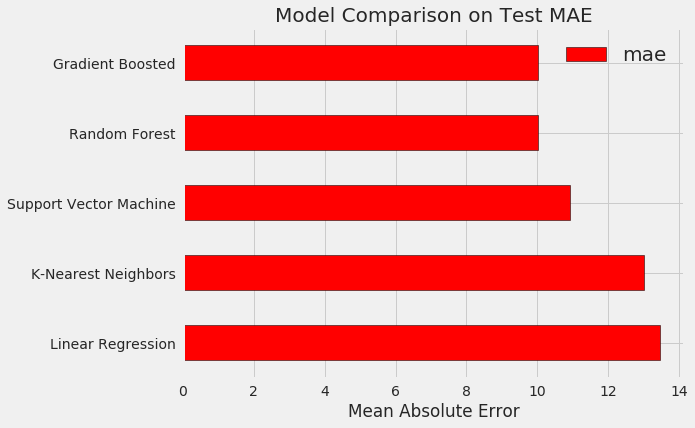

In [18]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe com os resultados de cada modelo
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                          'Random Forest', 'Gradient Boosted',
                                          'K-Nearest Neighbors'],
                                'mae': [lr_mae, svm_mae, random_forest_mae,
                                       gradient_boost_mae, knn_mae]})

# Gráfico de barra horizontal com os resultados MAE de cada modelo
model_comparison.sort_values('mae', ascending=False).plot(
    x='model', y='mae', kind='barh', color='red', edgecolor='black')

plt.ylabel('')
plt.xlabel('Mean Absolute Error')
plt.title('Model Comparison on Test MAE', size=20)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

Para colocar esses números em perspectiva, a linha de base ingênua calculada usando o valor mediano do alvo foi de 24,5. Claramente, o aprendizado de máquina é aplicável ao nosso problema por causa da melhoria significativa em relação à linha de base!

O [Gradient Boosted Regressor](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) (MAE = 10.0132) um pouco melhor que o Random Forest (10.0147 MAE). Esses resultados não são totalmente justos porque estamos usando principalmente os valores padrão dos hiperparâmetros. [Especialmente em modelos como Support Vector Machine](http://pyml.sourceforge.net/doc/howto.pdf), o desempenho é altamente dependente dessas configurações. No entanto, a partir desses resultados, vamos selecionar o Gradient Boosted Regressor para otimização do modelo.

# Ajuste de hiperparâmetros para otimização de modelos

No aprendizado de máquina, depois de termos selecionado um modelo, podemos otimizá-lo para o nosso problema, ajustando os hiperparâmetros do modelo.

Primeiro, quais são os [hiperparâmetros e como eles diferem dos parâmetros](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)?

- Os **hiperparâmetros** do modelo são melhor considerados como configurações para um algoritmo de aprendizado de máquina que são definidos pelo cientista de dados antes do treinamento. Exemplos seriam o número de árvores em uma random forest ou o número de vizinhos usados no algoritmo K-nearest neighbors.


- Os **parâmetros** do modelo são o que o modelo aprende durante o treinamento, como pesos em uma regressão linear.

Controlar os hiperparâmetros afeta o desempenho do modelo, alterando o equilíbrio entre [underfitting e overfitting](https://towardsdatascience.com/overfitting-vs-underfitting-a-conceptual-explanation-d94ee20ca7f9) em um modelo. O underfitting é quando nosso modelo não é complexo o suficiente (ele não possui graus de liberdade suficientes) para aprender o mapeamento de features para o target. Um modelo de underfit tem [alto viés](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), o que podemos corrigir tornando nosso modelo mais complexo.

Overfitting é quando nosso modelo essencialmente memoriza os dados de treinamento. Um modelo de overfit tem [alta variância](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), que podemos corrigir limitando a complexidade do modelo por meio da regularização. Tanto um modelo de underfit quanto um overfit não serão capazes de generalizar bem os dados de teste.

O problema com a escolha dos hiperparâmetros certos é que o conjunto ideal será diferente para cada problema de aprendizado de máquina! Portanto, a única maneira de encontrar as melhores configurações é testar várias delas em cada novo conjunto de dados. Felizmente, o Scikit-Learn tem vários métodos que nos permitem avaliar com eficiência os hiperparâmetros. Além disso, projetos como o [TPOT do Epistasis Lab](https://epistasislab.github.io/tpot/) estão tentando otimizar a busca por hiperparâmetros usando métodos como [programação genética](https://en.wikipedia.org/wiki/Genetic_programming). Neste projeto, vamos continuar fazendo isso com o Scikit-Learn, mas continuamos ligados para mais trabalhos na cena auto-ML!

# Pesquisa aleatória com validação cruzada

O método específico de ajuste de hiperparâmetros que implementaremos é chamado de pesquisa aleatória com validação cruzada:

- **[Pesquisa aleatória](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Random_search)** refere-se à técnica que usaremos para selecionar hiperparâmetros. Definimos uma grade e, em seguida, amostramos aleatoriamente diferentes combinações, em vez de pesquisar em grade, onde exaustivamente experimentamos todas as combinações. (Surpreendentemente, [a pesquisa aleatória executa quase tão bem quanto a pesquisa de grade](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) com uma redução drástica no tempo de execução).


- **[Validação cruzada](https://www.openml.org/a/estimation-procedures/1)** é a técnica que usamos para avaliar uma combinação selecionada de hiperparâmetros. Em vez de dividir o treinamento em conjuntos de treinamento e validação separados, o que reduz a quantidade de dados de treinamento que podemos usar, usamos a Validação Cruzada de K-fold. Isso envolve dividir os dados de treinamento em K folds e depois passar por um processo iterativo em que primeiro treinamos o fold K-1 e depois avaliamos o desempenho do fold Kth. Repetimos este processo K vezes e no final da validação cruzada de K, tomamos o erro médio em cada uma das K iterações como a medida final de desempenho.

A ideia da validação cruzada K-Fold com K = 5 é mostrada abaixo:

![alt text](https://cdn-images-1.medium.com/max/800/1*rgba1BIOUys7wQcXcL4U5A.png)

Todo o processo de realização de pesquisa aleatória com validação cruzada é:

1. Configurar uma grade de hiperparâmetros para avaliar
2. Amostra aleatória de uma combinação de hiperparâmetros
3. Criar um modelo com a combinação selecionada
4. Avaliar o modelo usando validação cruzada K-fold
5. Decidir quais hiperparâmetros funcionaram melhor

Claro, nós não fazemos isso manualmente, mas deixamos que o `RandomizedSearchCV` do Scikit-Learn cuide de todo o trabalho!

# Breve Contextualização: [Métodos do Gradient Boosted](https://en.wikipedia.org/wiki/Gradient_boosting)

Já que usaremos o modelo Gradient Boosted Regression, eu deveria dar pelo menos um pouco de experiência! Este modelo é um método conjunto, o que significa que é construído a partir de muitos "aprendizes fracos", neste caso árvores de decisão individuais. Enquanto um algoritmo de [conjunto como floresta aleatória](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) treina os aprendizes fracos em paralelo e os faz votar para fazer uma previsão, um [método boost](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) como o Gradient Boosting, treina os aprendizes em sequência, com cada aprendiz “concentrado” nos erros cometidos pelos anteriores.

Os métodos de boost tornaram-se populares nos últimos anos e frequentemente vencem competições de aprendizado de máquina. O [Método de Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) é uma implementação específica que usa o Gradiente Descendente para minimizar a função de custo, treinando sequencialmente os aprendizes sobre os resíduos dos anteriores. A implementação Scikit-Learn do Gradient Boosting é geralmente considerada menos eficiente do que outras bibliotecas como o [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html), mas funcionará bem o suficiente para nosso pequeno conjunto de dados e será bastante precisa.

# De volta ao ajuste dos Hiperparâmetros

Existem muitos hiperparâmetros para "tunar" um Gradient Boosted Regressor e você pode consultar a [documentação do Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) para obter detalhes. Vamos otimizar os seguintes hiperparâmetros:

- `loss`: a função de perda para minimizar
- `n_estimators`: o número de aprendizes fracos (árvores de decisão) para usar
- `max_depth`, a profundidade máxima de cada Árvore de Decisão
- `min_samples_leaf`: o número mínimo de exemplos requeridos em um nó folha da árvore de decisão
- `min_samples_split`: o número mínimo de exemplos necessários para dividir um nó da árvore de decisão
- `max_features`: o número máximo de features a serem usadas para dividir os nós

Não tenho certeza se existe alguém que realmente entenda como tudo isso interage, e a única maneira de encontrar a melhor combinação é experimentá-los!

No código a seguir, criamos uma grade de hiperparâmetro, criamos um objeto `RandomizedSearchCV` e realizamos uma pesquisa de hiperparâmetro usando validação cruzada de 4 folds em 25 combinações diferentes de hiperparâmetros:

In [19]:
# Função de perda para otimizar
loss = ['ls', 'lad', 'huber']

# Número de árvores usadas no processo de boosting
n_estimators = [100, 500, 900, 1100, 1500]

# Profundidade máxima de cada árvore
max_depth = [2, 3, 5, 10, 15]

# Número mínimo de exemplos por folha
min_samples_leaf = [1, 2, 4, 6, 8]

# Número mínimo de examples para dividir um nó
min_samples_split = [2, 4, 6, 10]

# Número máximo de features a considerar para fazer as divisões
max_features = ['auto', 'sqrt', 'log2', None]

# Define o grid dos hiperparâmetros para buscar
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Cria o modelo a ser usado para o ajuste dos hiperparâmetros
model = GradientBoostingRegressor(random_state=42)

# Configura a busca aleatória com validação cruzada de 4 folds
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=1,
                               return_train_score=True,
                               random_state=42)

# Realiza o treinamento
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

O Scikit-learn usa o erro absoluto médio negativo para avaliação porque deseja uma métrica para maximizar. Portanto, uma pontuação melhor será mais próxima de 0. Podemos obter os resultados da pesquisa aleatória em um dataframe e classificar os valores por desempenho.

In [20]:
# Pega todos os resultados e ordena pela performance no teste
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending=False)
random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,6.352778,0.188880,0.012874,0.000369,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.859381,-8.773966,-9.325139,-9.036779,-8.998761,0.210901,1,-7.027368,-6.837958,-6.869084,-6.840749,-6.893790,0.078077
3,7.848502,0.576674,0.015949,0.004225,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.868788,-8.904791,-9.315304,-9.075321,-9.041004,0.176509,2,-4.482073,-4.326121,-4.823009,-4.229809,-4.465253,0.225313
9,4.622449,0.130675,0.008984,0.000194,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.134318,-9.042461,-9.441179,-9.152240,-9.192518,0.149456,3,-7.007604,-7.088986,-6.913108,-6.940327,-6.987506,0.067939
0,1.491272,0.052483,0.004019,0.000095,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.101610,-9.026912,-9.456259,-9.201033,-9.196413,0.162211,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,4.272874,0.305248,0.011953,0.004900,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.146159,-9.199358,-9.699696,-9.357220,-9.350555,0.215966,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,39.226953,1.540403,0.059477,0.002193,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.261256,-9.243867,-9.528538,-9.473096,-9.376652,0.125816,6,-0.378166,-0.459465,-0.393491,-0.370483,-0.400401,0.035092
19,8.615662,0.371105,0.016181,0.001859,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.379335,-9.382576,-9.473980,-9.290880,-9.381693,0.064740,7,-8.311796,-8.658903,-7.820534,-8.017995,-8.202307,0.316303
2,27.088613,1.006865,0.032591,0.001321,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.385744,-9.288317,-9.572674,-9.429825,-9.419115,0.102366,8,-0.164859,-0.193613,-0.164415,-0.141062,-0.165987,0.018629
16,10.681647,0.383938,0.026026,0.001068,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.246573,-9.317156,-9.798950,-9.424668,-9.446787,0.212942,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,2.952137,0.062143,0.015980,0.000439,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.393840,-9.289175,-9.750806,-9.407503,-9.460295,0.173829,10,-5.684121,-5.742441,-5.571781,-5.666476,-5.666205,0.061337


Depois de realizar a pesquisa, podemos inspecionar o objeto `RandomizedSearchCV` para encontrar o melhor modelo:

In [21]:
# Exibe a melhor combinação de configurações
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

O melhor modelo de Gradient Boosted possui os seguintes hiperparâmetros:

- loss = lad
- n_estimators = 500
- max_depth = 5
- min_samples_leaf = 6
- min_samples_split = 6
- max_features = None (Isso significa que max_features = n_features de acordo com a documentação)

Usar a pesquisa aleatória é um bom método para restringir os possíveis hiperparâmetros. Inicialmente, não tínhamos ideia de qual combinação funcionaria melhor, mas isso, pelo menos, restringe o leque de opções.

No entanto, é improvável que novos ajustes melhorem significativamente o nosso modelo. Como regra geral, a engenharia de features apropriada terá um impacto muito maior no desempenho do modelo do que até mesmo o ajuste mais amplo do hiperparâmetro. É a [lei dos retornos decrescentes aplicada ao aprendizado de máquina](http://www.picnet.com.au/blogs/guido/2018/04/13/diminishing-returns-machine-learning-projects/): a engenharia de recursos leva você até a maior parte do caminho, e o ajuste de hiperparâmetro geralmente fornece apenas um pequeno benefício.

No entanto, em vez de avaliar todas essas configurações novamente, iremos focar em uma única, o número de árvores (n_estimators). Ao variar apenas um hiperparâmetro, podemos observar diretamente como isso afeta o desempenho. No caso do número de árvores, esperamos ver um efeito significativo na quantidade de under vs overfitting.

Aqui, usaremos a pesquisa de grade com uma grade que tenha apenas o hiperparâmetro n_estimators. Vamos avaliar uma série de árvores, em seguida, plotar o desempenho de treinamento e testes para ter uma idéia do que o aumento do número de árvores faz para o nosso modelo. Nós fixaremos os outros hiperparâmetros nos melhores valores retornados da busca aleatória para isolar o efeito do número de árvores.

In [22]:
# Cria uma faixa de arvóres para avaliar
tree_grids = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss='lad', max_depth=5, 
                                  min_samples_leaf=6, 
                                  min_samples_split=6, 
                                  max_features=None, 
                                  random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=tree_grids, cv=4, 
                           scoring='neg_mean_absolute_error', verbose=1,
                           n_jobs=-1, return_train_score=True)

# Treina o grid
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

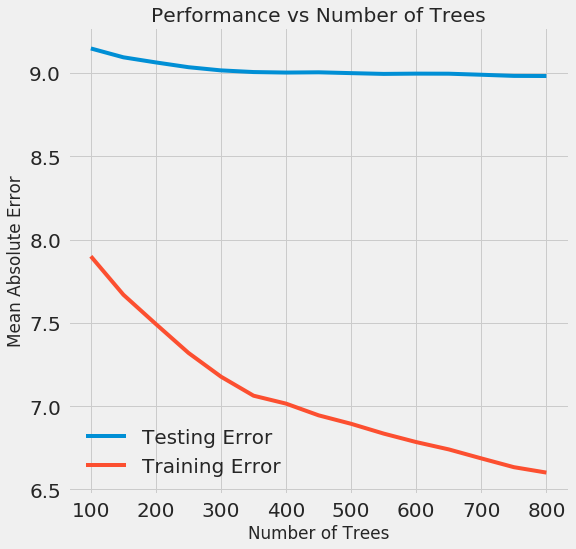

In [23]:
# Cria um dataframe com os resultados do GridSearch
results = pd.DataFrame(grid_search.cv_results_)

# Plot a comparação entre o erro de treino e teste e o número de árvores
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label='Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label='Training Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.title('Performance vs Number of Trees')
plt.legend()
plt.show()

À medida que o número de árvores usadas pelo modelo aumenta, tanto o erro de treinamento quanto o erro de teste diminuem. No entanto, o erro de treinamento diminui muito mais rapidamente do que o erro de teste e podemos ver que nosso modelo está com overfiting: ele funciona muito bem nos dados de treinamento, mas não consegue atingir o mesmo desempenho no conjunto de testes.

Sempre esperamos pelo menos alguma diminuição no desempenho no conjunto de testes (afinal, o modelo pode ver as respostas verdadeiras para o conjunto de treinamento), mas uma lacuna significativa indica [overfiting](https://www.kdnuggets.com/2015/01/clever-methods-overfitting-avoid.html). Podemos lidar com o overfitting obtendo mais dados de treinamento ou diminuindo a [complexidade do nosso modelo por meio dos hiperparâmetros](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/). Neste caso, deixaremos os hiperparâmetros onde estão, mas encorajo qualquer um a tentar reduzir o overfitting.

Com base nos resultados da validação cruzada, o melhor modelo usando 800 árvores e obtém um erro de validação cruzada abaixo de 9. Isso indica que a estimativa média de validação cruzada do Energy Star Score está a 9 pontos da resposta verdadeira!. Agora, hora de testar este modelo!

# Avaliando no Conjunto de Testes

Como engenheiros responsáveis de aprendizado de máquina, nos certificamos de não deixar nosso modelo ver o conjunto de testes em nenhum ponto de treinamento. Portanto, podemos usar o [desempenho do conjunto de testes como um indicador](https://www.coursera.org/learn/deep-neural-network/lecture/cxG1s/train-dev-test-sets) de quão bem nosso modelo executaria quando implantado no mundo real.

Fazer previsões no conjunto de testes e calcular o desempenho é relativamente simples. Aqui, comparamos o desempenho padrão do Gradient Boosted Regressor ao modelo ajustado:

In [24]:
# Modelo padrão
default_model = GradientBoostingRegressor(random_state=42)

In [25]:
# Seleciona o melhor modelo visto anteriormente
final_model = grid_search.best_estimator_
final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [26]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

751 ms ± 13.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [27]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

10.9 s ± 102 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Performance do modelo padrão no conjunto de teste: MAE = %0.4f' % mae(y_test, default_pred))
print('Performance do modelo final no conjunto de teste: MAE = %0.4f' % mae(y_test, final_pred))

Performance do modelo padrão no conjunto de teste: MAE = 10.0118
Performance do modelo final no conjunto de teste: MAE = 9.0446


O ajuste de jiperparâmetros melhorou a precisão do modelo em cerca de 10%. Dependendo do caso de uso, 10% poderia ser uma melhoria muito grande, mas veio em um investimento de tempo significativo! O aprendizado de máquina é [jogo de trocas](http://people.inf.ethz.ch/jaggim/meetup/slides/ML-meetup-9-vonRohr-kaggle.pdf): acurácia versus interpretabilidade, [viés vs variância](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/), precisão vs tempo de execução e a decisão final de qual modelo usar depende da situação. Aqui, o aumento no tempo de execução não é um impedimento, porque enquanto a diferença relativa é grande, a magnitude absoluta do tempo de treinamento não é significativa. Em uma situação diferente, o equilíbrio pode não ser o mesmo, então precisamos considerar o que estamos otimizando e as limitações com as quais temos que trabalhar.

Para ter uma ideia das previsões, podemos traçar a distribuição dos valores verdadeiros no conjunto de testes e os valores previstos no conjunto de testes.

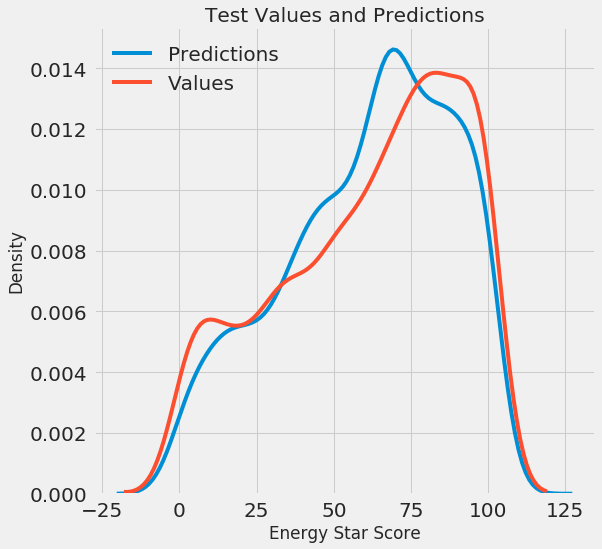

In [29]:
figsize(8, 8)

# Gráfico de densidade das predições do modelo final no conjunto de teste
sns.kdeplot(final_pred, label='Predictions')
sns.kdeplot(y_test, label='Values')

plt.xlabel('Energy Star Score')
plt.ylabel('Density')
plt.title('Test Values and Predictions')
plt.show()

As previsões do modelo parecem seguir a distribuição dos valores reais, embora o pico na densidade ocorra mais próximo do valor mediano (66) no conjunto de treinamento do que no pico real da densidade (que é próximo de 100).

Outro gráfico de diagnóstico é um histograma dos resíduos. Idealmente, esperamos que os resíduos sejam normalmente distribuídos, o que significa que o modelo está errado na mesma quantidade em ambas as direções (alta e baixa).

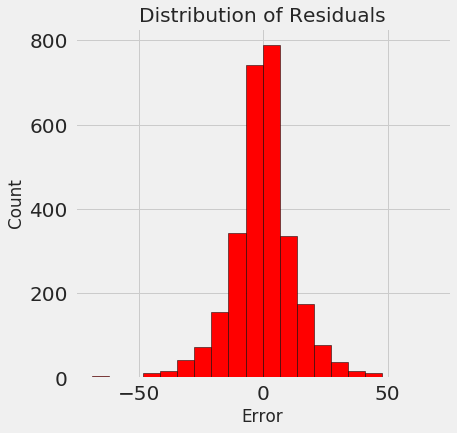

In [30]:
figsize(6, 6)

# Calcula os resíduos
residuals = final_pred - y_test

plt.hist(residuals, color='red', bins=20, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')
plt.show()

Os resíduos são quase que uma distribuição normal, embora vejamos alguns valores negativos grandes onde as previsões do modelo estavam muito abaixo dos valores verdadeiros.

# Conclusões

Neste artigo, abordamos várias etapas no fluxo de trabalho de aprendizado de máquina:

* Imputação de valores ausentes e dimensionamento de recursos
* Avaliação e comparação de vários modelos de aprendizado de máquina
* Ajuste de hiperparâmetros usando pesquisa de grade aleatória e validação cruzada
* Avaliação do melhor modelo no conjunto de teste

Os resultados deste trabalho mostraram que o aprendizado de máquina é aplicável à tarefa de prever a pontuação do Energy Star de um prédio usando os dados disponíveis. Usando um `gradient boosted regressor`, conseguimos prever as pontuações no conjunto de teste dentro de 8.5 pontos do valor verdadeiro. Além disso, vimos que o ajuste de hiperparâmetros pode aumentar o desempenho de um modelo a um custo significativo em termos de tempo investido. Este é um dos muitos trade-offs que temos de considerar ao desenvolver uma solução de aprendizado de máquina.

No terceiro notebook ([disponível aqui](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20Three.ipynb)), veremos a caixa preta que criamos e tentamos entender como nosso modelo faz previsões. Também determinaremos os maiores fatores que influenciam o Energy Star Score. Embora saibamos que nosso modelo é preciso, queremos saber por que ele faz as previsões e o que isso nos diz sobre o problema!